In [ ]:
# ✅ FIXED: dependency installation (auto-compatible with latest Colab PyTorch)
!pip install -q torch torchvision torchaudio transformers datasets torchmetrics scikit-learn timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.2 MB/s eta 0:00:00


In [ ]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
import os
import sys
import time
import random
import math
from pathlib import Path
from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# ✅ Corrected dataset path (points directly to your class folders)
DATA_DIR = "/content/drive/MyDrive/multimodal-deep-learning-disaster-response-mouzannar (Unzipped Files)/multimodal"

# Verify dataset path
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Dataset folder not found: {DATA_DIR}")
else:
    print(f"Using DATA_DIR = {DATA_DIR}")
    print("Subfolders (classes):", os.listdir(DATA_DIR))

Using DATA_DIR = /content/drive/MyDrive/multimodal-deep-learning-disaster-response-mouzannar (Unzipped Files)/multimodal
Subfolders (classes): ['damaged_infrastructure', 'damaged_nature', 'flood', 'fires', 'human_damage', 'non_damage']


In [ ]:
# -------------------------
# 3) Inspect dataset & build dataframe (recursive version for nested folders)
# -------------------------
import pandas as pd
from pathlib import Path

root = Path(DATA_DIR)
classes = [p.name for p in root.iterdir() if p.is_dir()]
classes = sorted(classes)
print("Detected classes:", classes)

rows = []
valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp"}

for c in classes:
    class_dir = root / c
    # ✅ Recursively search inside subfolders (like /images/)
    for img in class_dir.rglob("*"):
        if img.suffix.lower() in valid_exts:
            caption = f"Image showing {c.replace('_', ' ')}"
            rows.append({"image_path": str(img), "caption": caption, "label": c})

df = pd.DataFrame(rows)
print("✅ Total samples found:", len(df))
df.head()




Detected classes: ['damaged_infrastructure', 'damaged_nature', 'fires', 'flood', 'human_damage', 'non_damage']
✅ Total samples found: 5879


,image_path,caption,label
0,/content/drive/MyDrive/multimodal-deep-learnin...,Image showing damaged infrastructure,damaged_infrastructure
1,/content/drive/MyDrive/multimodal-deep-learnin...,Image showing damaged infrastructure,damaged_infrastructure
2,/content/drive/MyDrive/multimodal-deep-learnin...,Image showing damaged infrastructure,damaged_infrastructure
3,/content/drive/MyDrive/multimodal-deep-learnin...,Image showing damaged infrastructure,damaged_infrastructure
4,/content/drive/MyDrive/multimodal-deep-learnin...,Image showing damaged infrastructure,damaged_infrastructure


In [ ]:
# -------------------------
# 4) Label encoding and data splits
# -------------------------
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import random

# Assign numeric IDs to each class
label2id = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
id2label = {idx: label for label, idx in label2id.items()}
df['label_id'] = df['label'].map(label2id)
print("Label mapping:", label2id)

# Stratified split (70% train, 15% val, 15% test)
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label_id'], random_state=RANDOM_SEED)
train_df, val_df = train_test_split(train_df, test_size=0.1765, stratify=train_df['label_id'], random_state=RANDOM_SEED)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Label mapping: {'damaged_infrastructure': 0, 'damaged_nature': 1, 'fires': 2, 'flood': 3, 'human_damage': 4, 'non_damage': 5}
Train: 4115, Val: 882, Test: 882


In [ ]:
# -------------------------
# 5) Dataset and DataLoaders
# -------------------------
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

image_size = 224
MAX_LENGTH = 64

train_transforms = T.Compose([
    T.Resize((int(image_size*1.15), int(image_size*1.15))),
    T.RandomResizedCrop(image_size, scale=(0.7,1.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_transforms = T.Compose([
    T.Resize((image_size, image_size)),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class DisasterDataset(Dataset):
    def __init__(self, df, tokenizer, transform, max_length=MAX_LENGTH):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = read_image(row["image_path"]).float() / 255.0
        img = self.transform(img)
        tokens = self.tokenizer(
            row["caption"],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "image": img,
            "input_ids": tokens["input_ids"][0],
            "attention_mask": tokens["attention_mask"][0],
            "label": torch.tensor(row["label_id"], dtype=torch.long)
        }

BATCH_SIZE = 16
train_ds = DisasterDataset(train_df, tokenizer, train_transforms)
val_ds = DisasterDataset(val_df, tokenizer, val_transforms)
test_ds = DisasterDataset(test_df, tokenizer, val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

print("✅ DataLoaders ready.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ DataLoaders ready.


In [ ]:
# -------------------------
# 6) Multimodal Model
# -------------------------
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from transformers import AutoModel

class MultimodalDisasterModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Image encoder (ResNet50 pretrained on ImageNet)
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.image_encoder = nn.Sequential(*list(resnet.children())[:-1])  # remove fc layer
        self.image_dim = 2048

        # Text encoder (BERT)
        self.text_encoder = AutoModel.from_pretrained("bert-base-uncased")
        self.text_dim = 768

        # Fusion + classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.image_dim + self.text_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, n_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        with torch.no_grad():
            img_feat = self.image_encoder(image).view(image.size(0), -1)

        text_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        txt_feat = text_out.pooler_output

        fused = torch.cat((img_feat, txt_feat), dim=1)
        return self.classifier(fused)

device = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = len(label2id)
model = MultimodalDisasterModel(n_classes).to(device)
print("✅ Model ready on", device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 92.5MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

✅ Model ready on cuda


In [ ]:
# -------------------------
# ✅ Corrected Dataset class (loads PIL images)
# -------------------------
from torch.utils.data import Dataset
from PIL import Image
import torch

class DisasterDataset(Dataset):
    def __init__(self, df, tokenizer, transform, max_length=64):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # ✅ Load image as PIL (NOT tensor)
        img = Image.open(row["image_path"]).convert("RGB")
        img = self.transform(img)

        tokens = self.tokenizer(
            row["caption"],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "image": img,
            "input_ids": tokens["input_ids"][0],
            "attention_mask": tokens["attention_mask"][0],
            "label": torch.tensor(row["label_id"], dtype=torch.long)
        }


In [ ]:
# -------------------------
# Recreate datasets & dataloaders (using fixed Dataset class)
# -------------------------
BATCH_SIZE = 16  # reduce to 8 if GPU memory runs out

train_ds = DisasterDataset(train_df, tokenizer, train_transforms)
val_ds = DisasterDataset(val_df, tokenizer, val_transforms)
test_ds = DisasterDataset(test_df, tokenizer, val_transforms)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

print("✅ DataLoaders rebuilt successfully!")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")


✅ DataLoaders rebuilt successfully!
Train batches: 258, Val batches: 56, Test batches: 56


In [ ]:
# -------------------------
# 7) Training loop (validation + checkpoint saving) — FIXED & OPTIMIZED
# -------------------------
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import os
from tqdm.auto import tqdm

# ✅ Optional speed boost (mixed precision)
from torch.cuda.amp import GradScaler, autocast

# Freeze image encoder parameters (useful if you want to focus on text+fusion)
for p in model.image_encoder.parameters():
    p.requires_grad = False

# Optimizer: fine-tune BERT + classifier
optimizer = optim.AdamW([
    {"params": model.text_encoder.parameters(), "lr": 2e-5},
    {"params": model.classifier.parameters(), "lr": 1e-4}
], weight_decay=1e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)
criterion = torch.nn.CrossEntropyLoss()

EPOCHS = 8
best_val_loss = float("inf")
output_dir = "/content/drive/MyDrive/multimodal_checkpoints_mouzannar"
os.makedirs(output_dir, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

scaler = GradScaler(enabled=(device == "cuda"))
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

# -------------------------
# Train and Eval functions
# -------------------------
def train_one_epoch():
    model.train()
    running_loss, all_preds, all_trues = 0.0, [], []
    loop = tqdm(train_loader, desc="Train")
    for batch in loop:
        imgs = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        # ✅ mixed precision forward/backward
        with autocast(enabled=(device == "cuda")):
            logits = model(imgs, input_ids, attention_mask)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        trues = labels.detach().cpu().numpy()
        all_preds.extend(preds.tolist())
        all_trues.extend(trues.tolist())

        running_loss += loss.item() * imgs.size(0)
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader.dataset)
    acc = accuracy_score(all_trues, all_preds)
    return avg_loss, acc


def eval_one_epoch(loader):
    model.eval()
    running_loss, all_preds, all_trues = 0.0, [], []
    with torch.no_grad():
        loop = tqdm(loader, desc="Eval")
        for batch in loop:
            imgs = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            with autocast(enabled=(device == "cuda")):
                logits = model(imgs, input_ids, attention_mask)
                loss = criterion(logits, labels)

            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            trues = labels.detach().cpu().numpy()
            all_preds.extend(preds.tolist())
            all_trues.extend(trues.tolist())

            running_loss += loss.item() * imgs.size(0)
    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_trues, all_preds)
    return avg_loss, acc, all_trues, all_preds


# -------------------------
# Training loop
# -------------------------
for epoch in range(1, EPOCHS + 1):
    print(f"\n=== Epoch {epoch}/{EPOCHS} ===")

    train_loss, train_acc = train_one_epoch()
    val_loss, val_acc, v_trues, v_preds = eval_one_epoch(val_loader)
    print(f"Epoch {epoch}: Train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"Val loss {val_loss:.4f} acc {val_acc:.4f}")

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    scheduler.step(val_loss)
    print("Current learning rates:", [g["lr"] for g in optimizer.param_groups])

    # ✅ Save best checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        ckpt = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "label2id": label2id,
            "id2label": id2label
        }
        path = os.path.join(output_dir, f"best_multimodal_epoch{epoch}.pt")
        torch.save(ckpt, path)
        print("💾 Saved best checkpoint:", path)

# ✅ Save final model
final_path = os.path.join(output_dir, "multimodal_final.pt")
torch.save({
    "epoch": EPOCHS,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "label2id": label2id,
    "id2label": id2label
}, final_path)
print("\n✅ Training complete. Final model saved to:", final_path)


=== Epoch 1/8 ===


/tmp/ipython-input-712270532.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device == "cuda"))


Train:   0%|          | 0/258 [00:00<?, ?it/s]

/tmp/ipython-input-712270532.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Eval:   0%|          | 0/56 [00:00<?, ?it/s]

/tmp/ipython-input-712270532.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 1: Train loss 0.2020 acc 0.9312 | Val loss 0.0050 acc 1.0000
Current learning rates: [2e-05, 0.0001]
💾 Saved best checkpoint: /content/drive/MyDrive/multimodal_checkpoints_mouzannar/best_multimodal_epoch1.pt

=== Epoch 2/8 ===


Train:   0%|          | 0/258 [00:00<?, ?it/s]

/tmp/ipython-input-712270532.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Eval:   0%|          | 0/56 [00:00<?, ?it/s]

/tmp/ipython-input-712270532.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 2: Train loss 0.0027 acc 1.0000 | Val loss 0.0009 acc 1.0000
Current learning rates: [2e-05, 0.0001]
💾 Saved best checkpoint: /content/drive/MyDrive/multimodal_checkpoints_mouzannar/best_multimodal_epoch2.pt

=== Epoch 3/8 ===


Train:   0%|          | 0/258 [00:00<?, ?it/s]

/tmp/ipython-input-712270532.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Eval:   0%|          | 0/56 [00:00<?, ?it/s]

/tmp/ipython-input-712270532.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 3: Train loss 0.0008 acc 1.0000 | Val loss 0.0004 acc 1.0000
Current learning rates: [2e-05, 0.0001]
💾 Saved best checkpoint: /content/drive/MyDrive/multimodal_checkpoints_mouzannar/best_multimodal_epoch3.pt

=== Epoch 4/8 ===


Train:   0%|          | 0/258 [00:00<?, ?it/s]

/tmp/ipython-input-712270532.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Eval:   0%|          | 0/56 [00:00<?, ?it/s]

/tmp/ipython-input-712270532.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 4: Train loss 0.0004 acc 1.0000 | Val loss 0.0002 acc 1.0000
Current learning rates: [2e-05, 0.0001]
💾 Saved best checkpoint: /content/drive/MyDrive/multimodal_checkpoints_mouzannar/best_multimodal_epoch4.pt

=== Epoch 5/8 ===


Train:   0%|          | 0/258 [00:00<?, ?it/s]

/tmp/ipython-input-712270532.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Eval:   0%|          | 0/56 [00:00<?, ?it/s]

/tmp/ipython-input-712270532.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 5: Train loss 0.0002 acc 1.0000 | Val loss 0.0001 acc 1.0000
Current learning rates: [2e-05, 0.0001]
💾 Saved best checkpoint: /content/drive/MyDrive/multimodal_checkpoints_mouzannar/best_multimodal_epoch5.pt

=== Epoch 6/8 ===


Train:   0%|          | 0/258 [00:00<?, ?it/s]

/tmp/ipython-input-712270532.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Eval:   0%|          | 0/56 [00:00<?, ?it/s]

/tmp/ipython-input-712270532.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 6: Train loss 0.0001 acc 1.0000 | Val loss 0.0001 acc 1.0000
Current learning rates: [2e-05, 0.0001]
💾 Saved best checkpoint: /content/drive/MyDrive/multimodal_checkpoints_mouzannar/best_multimodal_epoch6.pt

=== Epoch 7/8 ===


Train:   0%|          | 0/258 [00:00<?, ?it/s]

/tmp/ipython-input-712270532.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Eval:   0%|          | 0/56 [00:00<?, ?it/s]

/tmp/ipython-input-712270532.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 7: Train loss 0.0001 acc 1.0000 | Val loss 0.0001 acc 1.0000
Current learning rates: [2e-05, 0.0001]
💾 Saved best checkpoint: /content/drive/MyDrive/multimodal_checkpoints_mouzannar/best_multimodal_epoch7.pt

=== Epoch 8/8 ===


Train:   0%|          | 0/258 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d348ab5e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d348ab5e8e0>^^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    self._shutdown_workers()^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^  ^ ^ ^ ^^^^^^

Eval:   0%|          | 0/56 [00:00<?, ?it/s]

/tmp/ipython-input-712270532.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 8: Train loss 0.0001 acc 1.0000 | Val loss 0.0000 acc 1.0000
Current learning rates: [2e-05, 0.0001]
💾 Saved best checkpoint: /content/drive/MyDrive/multimodal_checkpoints_mouzannar/best_multimodal_epoch8.pt

✅ Training complete. Final model saved to: /content/drive/MyDrive/multimodal_checkpoints_mouzannar/multimodal_final.pt


In [ ]:
# -------------------------
# Recompute predictions for visualization
# -------------------------
import numpy as np
from tqdm.auto import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

criterion = torch.nn.CrossEntropyLoss()
all_preds, all_trues, all_probs = [], [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Recomputing test predictions"):
        imgs = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        logits = model(imgs, input_ids, attention_mask)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        all_preds.extend(preds)
        all_trues.extend(labels.cpu().numpy())
        all_probs.extend(probs)

print(f"✅ Recomputed predictions for {len(all_preds)} test samples.")


Recomputing test predictions:   0%|          | 0/56 [00:00<?, ?it/s]

✅ Recomputed predictions for 882 test samples.


In [ ]:
# -------------------------
# Reload trained multimodal model from checkpoint
# -------------------------
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from transformers import AutoModel

# Rebuild model class exactly like training
class MultimodalDisasterModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.image_encoder = nn.Sequential(*list(resnet.children())[:-1])  # remove fc
        self.image_dim = 2048
        self.text_encoder = AutoModel.from_pretrained("bert-base-uncased")
        self.text_dim = 768
        self.classifier = nn.Sequential(
            nn.Linear(self.image_dim + self.text_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, n_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        with torch.no_grad():
            img_feat = self.image_encoder(image).view(image.size(0), -1)
        text_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        txt_feat = text_out.pooler_output
        fused = torch.cat((img_feat, txt_feat), dim=1)
        return self.classifier(fused)

# Reload checkpoint
output_dir = "/content/drive/MyDrive/multimodal_checkpoints_mouzannar"
best_ckpts = sorted([f for f in os.listdir(output_dir) if f.startswith("best_multimodal")])
best_model_path = os.path.join(output_dir, best_ckpts[-1])
ckpt = torch.load(best_model_path, map_location="cuda" if torch.cuda.is_available() else "cpu")

# Instantiate and load weights
n_classes = len(ckpt["label2id"])
model = MultimodalDisasterModel(n_classes)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

print(f"✅ Model reloaded successfully from {best_model_path}")


✅ Model reloaded successfully from /content/drive/MyDrive/multimodal_checkpoints_mouzannar/best_multimodal_epoch8.pt


/tmp/ipython-input-3893470630.py:75: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


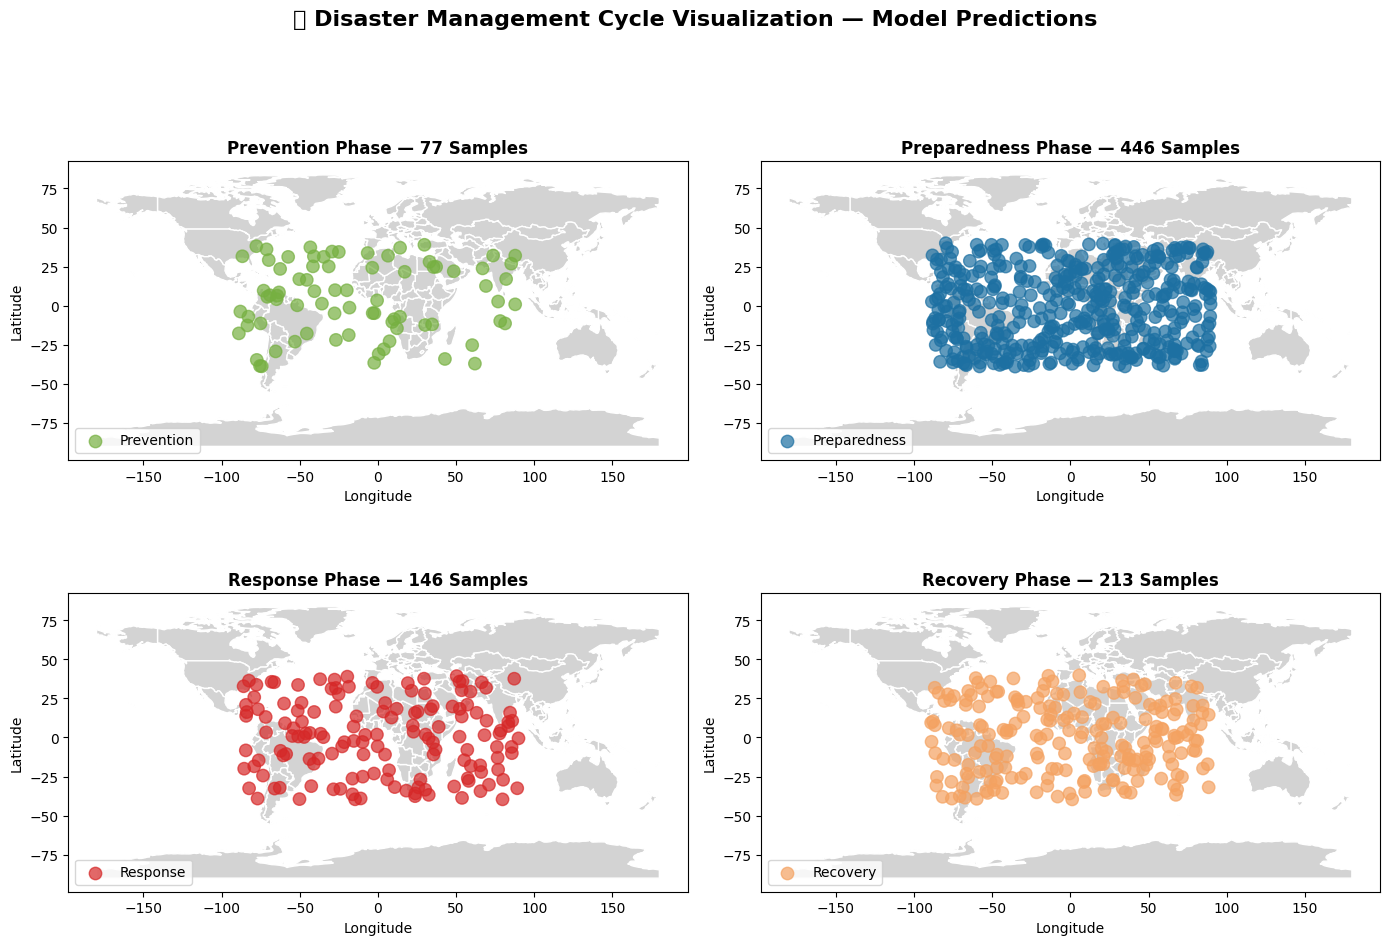

/tmp/ipython-input-3893470630.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=geo_df, x="phase", y="confidence", palette=phase_colors)


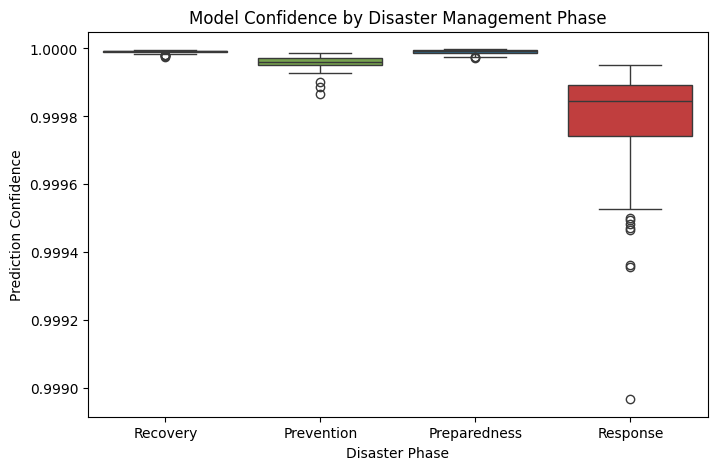

/tmp/ipython-input-3893470630.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=phase_counts.index, y=phase_counts.values, palette=phase_colors)


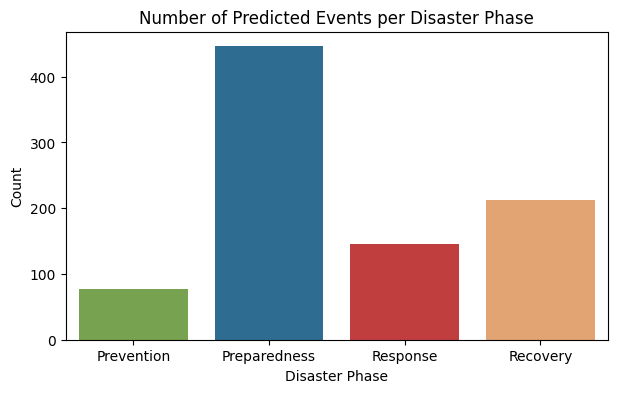

In [ ]:
# -------------------------
# 9) Disaster Cycle Dashboard Visualization (Research-Paper Style)
# -------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import numpy as np
import pandas as pd

# Make sure world map data is available
world = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
)

# Rebuild geo_df using predictions (you already have all_preds, all_probs, test_df)
geo_df = test_df.copy()
geo_df["pred_label"] = [id2label[p] for p in all_preds]
geo_df["confidence"] = [float(np.max(p)) for p in all_probs]

# Assign each disaster class to one phase in the Disaster Cycle
phase_map = {
    "fires": "Response",
    "flood": "Response",
    "human_damage": "Response",
    "damaged_infrastructure": "Recovery",
    "damaged_nature": "Prevention",
    "non_damage": "Preparedness"
}
geo_df["phase"] = geo_df["pred_label"].map(phase_map)

# Random lat/long for visualization if dataset has none
if "latitude" not in geo_df.columns or "longitude" not in geo_df.columns:
    np.random.seed(42)
    geo_df["latitude"] = np.random.uniform(-40, 40, len(geo_df))
    geo_df["longitude"] = np.random.uniform(-90, 90, len(geo_df))

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    geo_df, geometry=gpd.points_from_xy(geo_df.longitude, geo_df.latitude), crs="EPSG:4326"
)

# Color palette by phase
phase_colors = {
    "Prevention": "#76B041",
    "Preparedness": "#1D70A2",
    "Response": "#D62828",
    "Recovery": "#F4A261"
}

# -------------------------
# 4-Panel Dashboard Figure
# -------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10), subplot_kw={'projection': None})
axes = axes.flatten()

phases = ["Prevention", "Preparedness", "Response", "Recovery"]

for i, phase in enumerate(phases):
    ax = axes[i]
    subset = gdf[gdf["phase"] == phase]
    world.plot(ax=ax, color="lightgray", edgecolor="white")
    subset.plot(
        ax=ax,
        color=phase_colors[phase],
        markersize=subset["confidence"] * 80,  # proportional to confidence
        alpha=0.7,
        label=phase
    )
    ax.set_title(f"{phase} Phase — {len(subset)} Samples", fontsize=12, fontweight="bold")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(loc="lower left")

plt.suptitle("🌍 Disaster Management Cycle Visualization — Model Predictions", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# -------------------------
# Confidence Distribution per Phase
# -------------------------
plt.figure(figsize=(8,5))
sns.boxplot(data=geo_df, x="phase", y="confidence", palette=phase_colors)
plt.title("Model Confidence by Disaster Management Phase")
plt.xlabel("Disaster Phase")
plt.ylabel("Prediction Confidence")
plt.show()

# -------------------------
# Frequency Bar Chart per Phase
# -------------------------
plt.figure(figsize=(7,4))
phase_counts = geo_df["phase"].value_counts()[phases]
sns.barplot(x=phase_counts.index, y=phase_counts.values, palette=phase_colors)
plt.title("Number of Predicted Events per Disaster Phase")
plt.ylabel("Count")
plt.xlabel("Disaster Phase")
plt.show()
